In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from tools import Modelisation, datasets

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
df.shape

(1610494, 48)

**Définition des variables quantitatives, des variables catégorielles et des datasets :**

In [3]:
datasets_df = datasets(df)
X_quant = datasets_df['X_quant']
X_cat = datasets_df['X_cat']
X = datasets_df['X']
y = datasets_df['y']

Columns_quant :


['contextid',
 'campaignctrlast24h',
 'dayssincelastvisitdouble',
 'ltf_nbglobaldisplay_4w',
 'ltf_nbpartnerdisplayssincelastclick',
 'ltf_nbpartnerdisplay_90d',
 'ltf_nbpartnerclick_90d',
 'ltf_nbpartnersales_90d',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'display_size',
 'zonecostineuro']


Columns_cat :


['display_env',
 'target_env',
 'campaignscenario',
 'campaignvertical',
 'is_interstitial',
 'device_type',
 'hour',
 'weekday']


Nombre de variables pour X_quant : 13



Index(['contextid', 'campaignctrlast24h', 'dayssincelastvisitdouble',
       'ltf_nbglobaldisplay_4w', 'ltf_nbpartnerdisplayssincelastclick',
       'ltf_nbpartnerdisplay_90d', 'ltf_nbpartnerclick_90d',
       'ltf_nbpartnersales_90d', 'nbdayssincelastclick', 'nbdisplay_1hour',
       'nbdisplayglobalapprox_1d_sum_xdevice', 'display_size',
       'zonecostineuro'],
      dtype='object')


Nombre de variables pour X_cat : 50



Index(['display_env_app_ios', 'display_env_other', 'display_env_web',
       'target_env_2', 'campaignscenario_5', 'campaignscenario_6',
       'campaignscenario_11', 'campaignscenario_12', 'campaignscenario_13',
       'campaignscenario_17', 'campaignvertical_20.0', 'campaignvertical_23.0',
       'campaignvertical_129.0', 'campaignvertical_200002.0',
       'is_interstitial_True', 'device_type_Desktop',
       'device_type_Desktop - Safari', 'device_type_Mobile - Other',
       'device_type_Unknown', 'device_type_iPad', 'device_type_iPhone',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday'],
      dtype='object')


Nombre de variables pour X : 63


# Decision tree
## Variables quantitatives

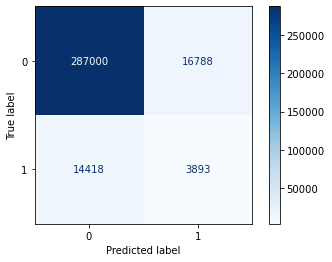

f1 : 0.1997
f3 : 0.2099
f5 : 0.2116
recall : 0.2126
negative predictive value : 0.9522
precision : 0.1882
roc_auc : 0.5787
training time : 15.814s
prediction time : 0.109s


In [4]:
m = Modelisation(X_quant, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

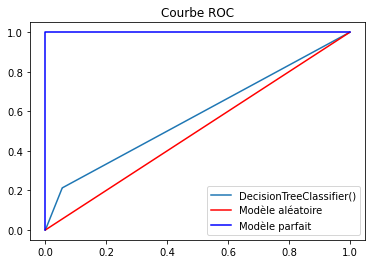

In [5]:
m.show_ROC()

In [6]:
m.show_attributes()

max_depth : 54
n_leaves : 92132
node_count : 184263


C:\Users\pasqu\Informatique\statapp\tools.py:163: RuntimeWarning: invalid value encountered in longlong_scalars
  Precision = TP / (TP + FP)


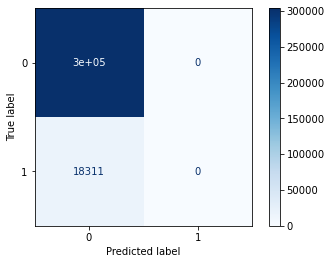

f1 : nan
f3 : nan
f5 : nan
recall : 0.0000
negative predictive value : 0.9432
precision : nan
roc_auc : 0.7374
training time : 1.849s
prediction time : 0.031s


In [7]:
m = Modelisation(X_quant, y, DecisionTreeClassifier(max_depth=2))
m.show_conf_matrix()
m.show_metrics_score()

In [8]:
m.show_attributes()

max_depth : 2
n_leaves : 4
node_count : 7


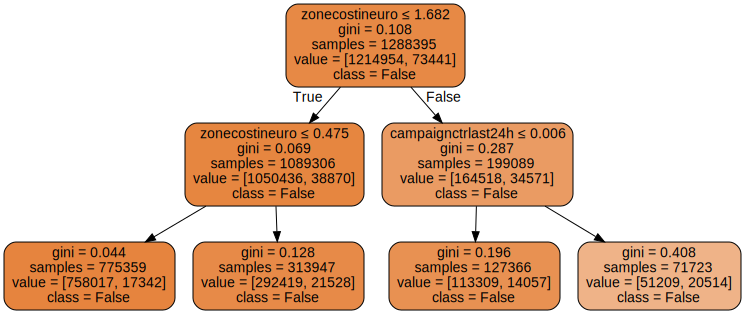

In [9]:
m.plot_tree()

## Variables catégorielles

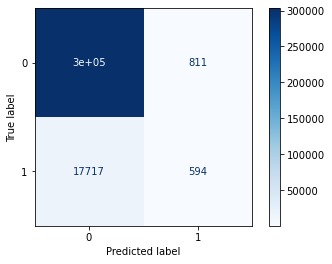

f1 : 0.0603
f3 : 0.0357
f5 : 0.0336
recall : 0.0324
negative predictive value : 0.9448
precision : 0.4228
roc_auc : 0.6568
training time : 15.998s
prediction time : 0.094s


In [10]:
m = Modelisation(X_cat, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

In [11]:
m.show_attributes()

max_depth : 47
n_leaves : 19798
node_count : 39595


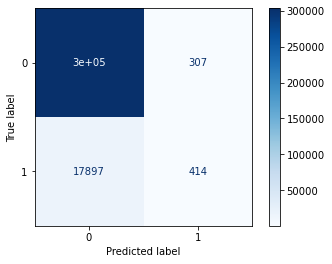

f1 : 0.0435
f3 : 0.0250
f5 : 0.0235
recall : 0.0226
negative predictive value : 0.9443
precision : 0.5742
roc_auc : 0.6738
training time : 3.875s
prediction time : 0.047s


In [12]:
m = Modelisation(X_cat, y, DecisionTreeClassifier(max_depth=5))
m.show_conf_matrix()
m.show_metrics_score()

In [13]:
m.show_attributes()

max_depth : 5
n_leaves : 32
node_count : 63


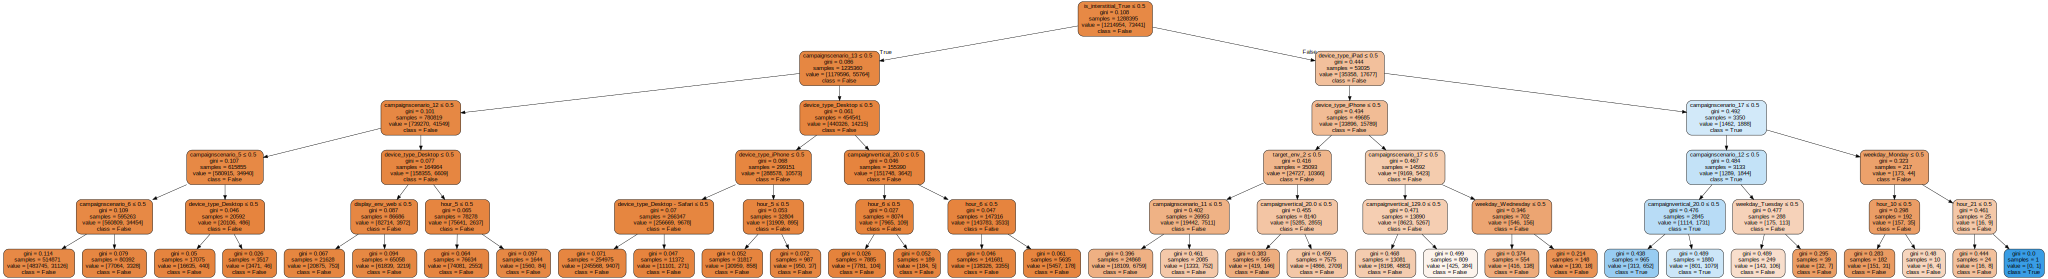

In [14]:
m.plot_tree()

## Variables quantitatives + catégorielles

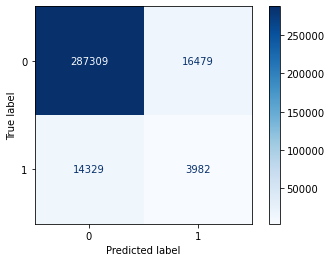

f1 : 0.2054
f3 : 0.2149
f5 : 0.2165
recall : 0.2175
negative predictive value : 0.9525
precision : 0.1946
roc_auc : 0.5816
training time : 37.1s
prediction time : 0.172s


In [15]:
m = Modelisation(X, y, DecisionTreeClassifier())
m.show_conf_matrix()
m.show_metrics_score()

In [16]:
m.show_attributes()

max_depth : 51
n_leaves : 87671
node_count : 175341


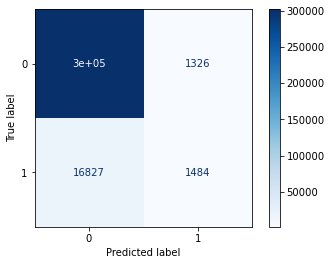

f1 : 0.1405
f3 : 0.0885
f5 : 0.0838
recall : 0.0810
negative predictive value : 0.9473
precision : 0.5281
roc_auc : 0.7795
training time : 6.683s
prediction time : 0.109s


In [17]:
m = Modelisation(X, y, DecisionTreeClassifier(max_depth=4))
m.show_conf_matrix()
m.show_metrics_score()

In [18]:
m.show_attributes()

max_depth : 4
n_leaves : 16
node_count : 31


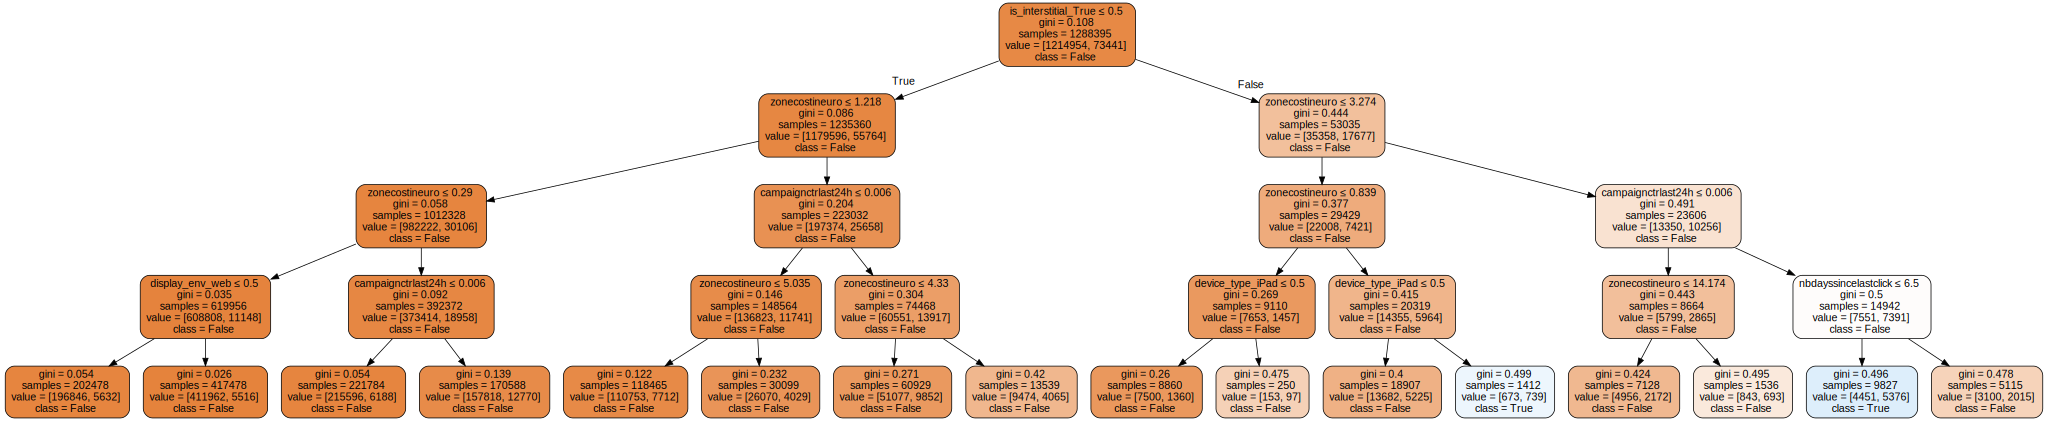

In [19]:
m.plot_tree()

# Random Forest

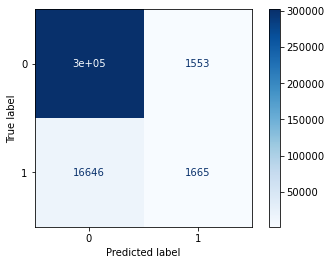

f1 : 0.1547
f3 : 0.0991
f5 : 0.0939
recall : 0.0909
negative predictive value : 0.9478
precision : 0.5174
roc_auc : 0.7348
training time : 18.914s
prediction time : 0.547s


In [20]:
m = Modelisation(X, y, RandomForestClassifier(n_estimators=10, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

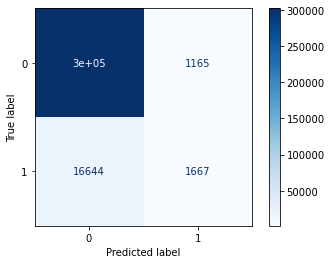

f1 : 0.1577
f3 : 0.0994
f5 : 0.0941
recall : 0.0910
negative predictive value : 0.9479
precision : 0.5886
roc_auc : 0.8120
training time : 2min, 44.375s
prediction time : 3.742s


In [21]:
m = Modelisation(X, y, RandomForestClassifier(n_estimators=100, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

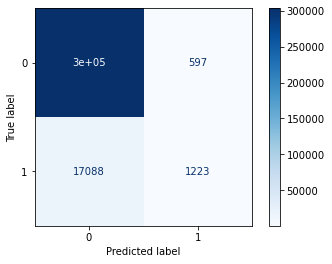

f1 : 0.1215
f3 : 0.0734
f5 : 0.0692
recall : 0.0668
negative predictive value : 0.9466
precision : 0.6720
roc_auc : 0.8312
training time : 2min, 31.135s
prediction time : 3.062s


In [22]:
m = Modelisation(X, y, RandomForestClassifier(min_samples_leaf=15, n_estimators=100, n_jobs=-1))
m.show_conf_matrix()
m.show_metrics_score()

In [23]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:08:03
